In [5]:
# Import libraries
import numpy as np
import pandas as pd
import yaml
import torch
from pathlib import Path
from sentence_transformers import SentenceTransformer
from PIL import Image
import requests
from io import BytesIO
import chromadb
import warnings
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

print("✅ Libraries imported")

✅ Libraries imported


In [2]:
# Setup paths and load config
ROOT = Path("..").resolve()
CONFIG_PATH = ROOT / "configs" / "config.yaml"

with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

VDB_DIR = ROOT / "outputs" / "vector_db"
DATA_PROCESSED = ROOT / config.get("data", {}).get("processed_path", "Data/processed/")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"📁 Root: {ROOT}")
print(f"🖥️  Device: {DEVICE}")

📁 Root: /home/roshan/Aria/mlops
🖥️  Device: cuda


In [6]:
# Load models and ChromaDB
TEXT_MODEL_NAME = config.get("feature_engineering", {}).get("text", {}).get("model_name", "paraphrase-multilingual-MiniLM-L12-v2")
IMAGE_MODEL_NAME = config.get("feature_engineering", {}).get("image", {}).get("model_name", "openai/clip-vit-base-patch32")

print("⏳ Loading models...")
text_model = SentenceTransformer(TEXT_MODEL_NAME, device=DEVICE)

# Load CLIP model using transformers
clip_model = CLIPModel.from_pretrained(IMAGE_MODEL_NAME).to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained(IMAGE_MODEL_NAME)
clip_model.eval()

print("⏳ Connecting to ChromaDB...")
chroma_client = chromadb.PersistentClient(path=str(VDB_DIR))
col_text = chroma_client.get_collection("products_text")
col_image = chroma_client.get_collection("products_image")

print(f"✅ Text collection: {col_text.count()} embeddings")
print(f"✅ Image collection: {col_image.count()} embeddings")

⏳ Loading models...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 9118.05it/s]


⏳ Connecting to ChromaDB...
✅ Text collection: 1022296 embeddings
✅ Image collection: 9982 embeddings


INFO:backoff:Backing off send_request(...) for 0.6s (requests.exceptions.SSLError: HTTPSConnectionPool(host='us.i.posthog.com', port=443): Max retries exceeded with url: /batch/ (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1010)'))))
INFO:backoff:Backing off send_request(...) for 2.0s (requests.exceptions.SSLError: HTTPSConnectionPool(host='us.i.posthog.com', port=443): Max retries exceeded with url: /batch/ (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1010)'))))
INFO:backoff:Backing off send_request(...) for 1.4s (requests.exceptions.SSLError: HTTPSConnectionPool(host='us.i.posthog.com', port=443): Max retries exceeded with url: /batch/ (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1010)'))))
ERROR:backoff:Giving up send_request(...) after 4 tries (requests.exceptions.SS

In [7]:
def text_retrieval(query: str, k: int = 5):
    """
    Text-only RAG retrieval.
    
    Args:
        query: Text query in Persian
        k: Number of top results to retrieve
    
    Returns:
        List of retrieved products with metadata
    """
    # Encode query
    query_embedding = text_model.encode([query], normalize_embeddings=True)
    
    # Retrieve from text collection
    results = col_text.query(
        query_embeddings=query_embedding.tolist(),
        n_results=k,
        include=["documents", "distances", "metadatas"]
    )
    
    # Format results
    retrieved = []
    for i in range(len(results["ids"][0])):
        retrieved.append({
            "rank": i + 1,
            "product_id": results["ids"][0][i],
            "distance": results["distances"][0][i],
            "score": 1 - results["distances"][0][i],  # Convert distance to similarity
            "text": results["documents"][0][i],
            "metadata": results["metadatas"][0][i]
        })
    
    return retrieved

print("✅ Text retrieval system ready")

✅ Text retrieval system ready


In [22]:
# Test text retrieval
test_queries_text = [
    "   خت خواب چوبی آرام",
    "ست کفگیر چوبی",
    "پوست کن سیب زمینی ویکتورینوکس مدل 7.6073."
]

print("=" * 70)
print("TEXT-ONLY RETRIEVAL TEST")
print("=" * 70)

for query in test_queries_text:
    print(f"\n🔍 Query: '{query}'")
    print("-" * 70)
    
    results = text_retrieval(query, k=3)
    
    for item in results:
        print(f"\n{item['rank']}. Product ID: {item['product_id']}")
        print(f"   Score: {item['score']:.4f}")
        print(f"   Brand: {item['metadata'].get('brand_title', 'N/A')}")
        print(f"   Category: {item['metadata'].get('category_title', 'N/A')}")
        print(f"   Text: {item['text'][:1000]}...")

TEXT-ONLY RETRIEVAL TEST

🔍 Query: '   خت خواب چوبی آرام'
----------------------------------------------------------------------

1. Product ID: qbpysf
   Score: 0.7263
   Brand: 
   Category: آباژور و چراغ خواب
   Text: چراغ خواب خوک خانم خوابیده | دسته: آباژور و چراغ خواب...

2. Product ID: fiipib
   Score: 0.7167
   Brand: 
   Category: آباژور و چراغ خواب
   Text: آباژور خام پایه چوبی کلاهک مخروطی | دسته: آباژور و چراغ خواب...

3. Product ID: ojagcr
   Score: 0.7153
   Brand: 
   Category: آباژور و چراغ خواب
   Text: چراغ خواب لوگو بتمن | دسته: آباژور و چراغ خواب...

🔍 Query: 'ست کفگیر چوبی'
----------------------------------------------------------------------

1. Product ID: ywanjb
   Score: 0.8087
   Brand: 
   Category: کفگیر و ملاقه
   Text: ست کفگیر چوبی | دسته: کفگیر و ملاقه...

2. Product ID: pvamoq
   Score: 0.8087
   Brand: 
   Category: کفگیر و ملاقه
   Text: ست کفگیر چوبی | دسته: کفگیر و ملاقه...

3. Product ID: dbcrip
   Score: 0.7932
   Brand: 
   Category: کفگیر و ملا

In [10]:
def image_retrieval(image_input, k: int = 5):
    """
    Image-only RAG retrieval.
    
    Args:
        image_input: PIL Image object or image URL
        k: Number of top results to retrieve
    
    Returns:
        List of retrieved products with metadata
    """
    # Load image if URL provided
    if isinstance(image_input, str):
        response = requests.get(image_input, timeout=10)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = image_input
    
    # Encode image using CLIP
    inputs = clip_processor(images=image, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    
    # Normalize embedding
    image_embedding = image_features / image_features.norm(dim=-1, keepdim=True)
    image_embedding = image_embedding.cpu().numpy().flatten()
    
    # Retrieve from image collection
    results = col_image.query(
        query_embeddings=[image_embedding.tolist()],
        n_results=k,
        include=["distances", "metadatas"]
    )
    
    # Format results
    retrieved = []
    for i in range(len(results["ids"][0])):
        retrieved.append({
            "rank": i + 1,
            "product_id": results["ids"][0][i],
            "distance": results["distances"][0][i],
            "score": 1 - results["distances"][0][i],
            "image_url": results["metadatas"][0][i].get("image_url", "N/A")
        })
    
    return retrieved

print("✅ Image retrieval system ready")

✅ Image retrieval system ready


IMAGE-ONLY RETRIEVAL TEST

🔍 Query Image: https://image.torob.com/base/images/cN/mO/cNmOWK3YhXZPMLmZ.jpg...
----------------------------------------------------------------------


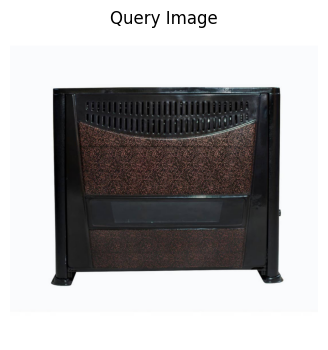


📋 Top 5 Similar Products:

1. Product ID: iahhml
   Score: 1.0000

2. Product ID: gqisfw
   Score: 0.6695

3. Product ID: oauwgn
   Score: 0.6442

4. Product ID: jgpqnp
   Score: 0.6422

5. Product ID: vzwmli
   Score: 0.6379


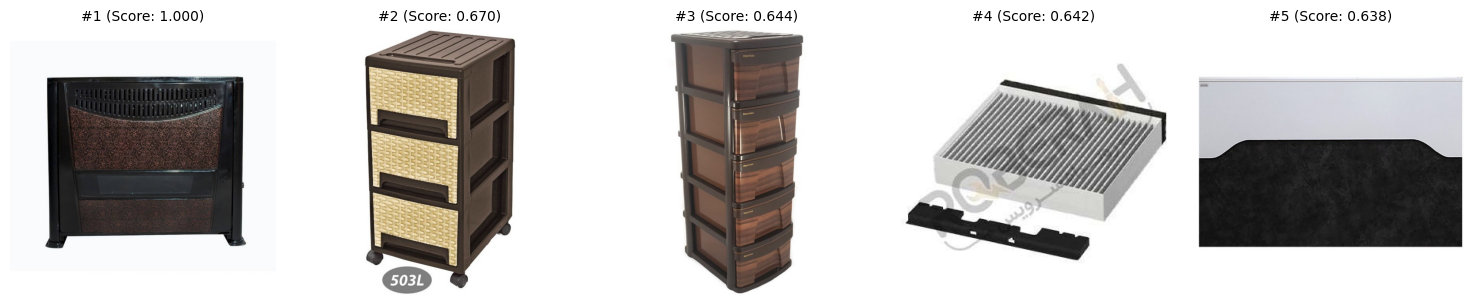

In [13]:
import matplotlib.pyplot as plt
from IPython.display import display

# Test image retrieval - get a sample image URL from the collection
sample_result = col_image.get(limit=1, include=["metadatas"])
if sample_result["ids"]:
    test_image_url = sample_result["metadatas"][0].get("image_url")
    
    print("=" * 70)
    print("IMAGE-ONLY RETRIEVAL TEST")
    print("=" * 70)
    print(f"\n🔍 Query Image: {test_image_url[:80]}...")
    print("-" * 70)
    
    try:
        # Display query image
        query_img = Image.open(BytesIO(requests.get(test_image_url, timeout=10).content))
        plt.figure(figsize=(4, 4))
        plt.imshow(query_img)
        plt.axis('off')
        plt.title("Query Image")
        plt.show()
        
        results = image_retrieval(test_image_url, k=5)
        
        # Display results with images
        print(f"\n📋 Top {len(results)} Similar Products:")
        fig, axes = plt.subplots(1, min(5, len(results)), figsize=(15, 3))
        if len(results) == 1:
            axes = [axes]
        
        for idx, item in enumerate(results):
            print(f"\n{item['rank']}. Product ID: {item['product_id']}")
            print(f"   Score: {item['score']:.4f}")
            
            # Display image
            try:
                img_url = item['image_url']
                img = Image.open(BytesIO(requests.get(img_url, timeout=10).content))
                axes[idx].imshow(img)
                axes[idx].axis('off')
                axes[idx].set_title(f"#{item['rank']} (Score: {item['score']:.3f})", fontsize=10)
            except:
                axes[idx].text(0.5, 0.5, 'Image Error', ha='center', va='center')
                axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"⚠️  Error: {e}")
else:
    print("⚠️  No images in collection for testing")

In [14]:
def multimodal_retrieval(text_query: str = None, image_input = None, 
                         k: int = 5, alpha: float = 0.5):
    """
    Multimodal RAG retrieval combining text and image.
    
    Args:
        text_query: Text query (optional)
        image_input: PIL Image or URL (optional)
        k: Number of top results
        alpha: Weight for text (1-alpha for image). Range [0, 1]
    
    Returns:
        List of retrieved products with combined scores
    """
    if text_query is None and image_input is None:
        raise ValueError("At least one of text_query or image_input must be provided")
    
    # Get text results
    text_scores = {}
    if text_query is not None:
        text_results = text_retrieval(text_query, k=k*2)  # Get more for fusion
        for item in text_results:
            text_scores[item["product_id"]] = item["score"]
    
    # Get image results
    image_scores = {}
    if image_input is not None:
        image_results = image_retrieval(image_input, k=k*2)
        for item in image_results:
            image_scores[item["product_id"]] = item["score"]
    
    # Combine scores (late fusion)
    all_ids = set(text_scores.keys()) | set(image_scores.keys())
    combined = []
    
    for product_id in all_ids:
        t_score = text_scores.get(product_id, 0.0)
        i_score = image_scores.get(product_id, 0.0)
        
        # Weighted combination
        if text_query is not None and image_input is not None:
            final_score = alpha * t_score + (1 - alpha) * i_score
        elif text_query is not None:
            final_score = t_score
        else:
            final_score = i_score
        
        combined.append({
            "product_id": product_id,
            "score": final_score,
            "text_score": t_score,
            "image_score": i_score
        })
    
    # Sort by combined score and take top-k
    combined.sort(key=lambda x: x["score"], reverse=True)
    
    # Enrich with metadata from text collection
    for item in combined[:k]:
        try:
            metadata = col_text.get(ids=[item["product_id"]], include=["metadatas", "documents"])
            if metadata["ids"]:
                item["metadata"] = metadata["metadatas"][0]
                item["text"] = metadata["documents"][0]
        except:
            item["metadata"] = {}
            item["text"] = ""
    
    # Add rank
    for i, item in enumerate(combined[:k]):
        item["rank"] = i + 1
    
    return combined[:k]

print("✅ Multimodal retrieval system ready")

✅ Multimodal retrieval system ready



MULTIMODAL RETRIEVAL TEST - Text + Image

🔍 Text Query: 'میز اتو'
🖼️  Image: https://image.torob.com/base/images/cN/mO/cNmOWK3YhXZPMLmZ.j...
📊 Alpha (text weight): 0.5
----------------------------------------------------------------------


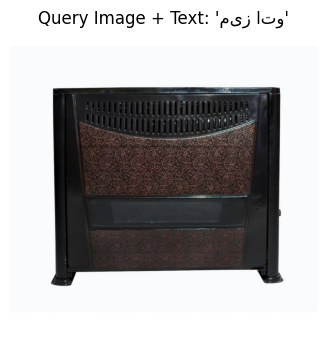


📋 Top 3 Multimodal Results:

1. Product ID: iahhml
   Combined Score: 0.5000
   Text Score: 0.0000 | Image Score: 1.0000
   Brand: جنرال سهند / General Sahand
   Category: بخاری گازی
   Text: بخاری گازی 14000 هزار جنرال سهند مدل هوشمند | برند: جنرال سهند / General Sahand ...


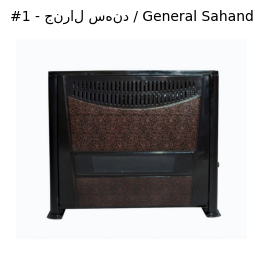


2. Product ID: gqisfw
   Combined Score: 0.3348
   Text Score: 0.0000 | Image Score: 0.6695
   Brand: 
   Category: دراور و کشو
   Text: فایل 3 طبقه سری L کد 503 | دسته: دراور و کشو...


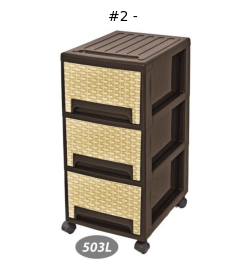


3. Product ID: bfbeix
   Combined Score: 0.3347
   Text Score: 0.6695 | Image Score: 0.0000
   Brand: 
   Category: لوازم اتو
   Text: میز اتو | دسته: لوازم اتو...


In [17]:
# Test multimodal retrieval - Text + Image combined
sample_result = col_image.get(limit=1, include=["metadatas"])
if sample_result["ids"]:
    test_image_url = sample_result["metadatas"][0].get("image_url")
    
    print("\n" + "=" * 70)
    print("MULTIMODAL RETRIEVAL TEST - Text + Image")
    print("=" * 70)
    
    query = "میز اتو"
    print(f"\n🔍 Text Query: '{query}'")
    print(f"🖼️  Image: {test_image_url[:60]}...")
    print(f"📊 Alpha (text weight): 0.5")
    print("-" * 70)
    
    try:
        # Display query image
        query_img = Image.open(BytesIO(requests.get(test_image_url, timeout=10).content))
        plt.figure(figsize=(4, 4))
        plt.imshow(query_img)
        plt.axis('off')
        plt.title(f"Query Image + Text: '{query}'")
        plt.show()
        
        results = multimodal_retrieval(
            text_query=query, 
            image_input=test_image_url, 
            k=3, 
            alpha=0.5
        )
        
        # Display results
        print(f"\n📋 Top {len(results)} Multimodal Results:")
        for item in results:
            print(f"\n{item['rank']}. Product ID: {item['product_id']}")
            print(f"   Combined Score: {item['score']:.4f}")
            print(f"   Text Score: {item['text_score']:.4f} | Image Score: {item['image_score']:.4f}")
            print(f"   Brand: {item['metadata'].get('brand_title', 'N/A')}")
            print(f"   Category: {item['metadata'].get('category_title', 'N/A')}")
            print(f"   Text: {item.get('text', '')[:80]}...")
            
            # Try to get and display image
            try:
                img_data = col_image.get(ids=[item['product_id']], include=["metadatas"])
                if img_data["ids"]:
                    img_url = img_data["metadatas"][0].get("image_url")
                    img = Image.open(BytesIO(requests.get(img_url, timeout=10).content))
                    plt.figure(figsize=(3, 3))
                    plt.imshow(img)
                    plt.axis('off')
                    plt.title(f"#{item['rank']} - {item['metadata'].get('brand_title', 'N/A')}", fontsize=10)
                    plt.show()
            except:
                print("   [Image not available]")
        
    except Exception as e:
        print(f"⚠️  Error: {e}")
else:
    print("⚠️  No images available for multimodal test")